#Bibliotecas

In [ ]:
import time
time.time()

1709832996.010704

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from mpl_toolkits import mplot3d
from scipy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from scipy.interpolate import CubicSpline, UnivariateSpline                 #tentativa spline
from scipy.signal import savgol_filter                                      #tentativa spline
import scipy.integrate as integrate
import scipy.special as special
import random as rd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Modelo parte 1




In [ ]:
wks_s = np.array([1.0, 1.96, 2.425, 3.63])           #% da população de monócitos ao longo da gravidez em relação a não grávida
wks_z = np.array([1.0, 0.81, 0.64, 0.57])            #% da população de linfócitos ao longo da gravidez em relação a não grávida
wks_IFN = np.array([1.0, 0.5963, 0.5611, 1.0704])    #% da produção de linfócitos-T com o mesmo estímulo
a = np.array([0.001, 0.002, 0.003])                  #taxa de invasão bem-sucedida em um monócito susceptível
wks_mu = 80 * wks_s                                  #monócitos produzidos/dia.uL
wks_eta = 0.265 * wks_z                              #linfo-T produzidos/dia.uL para equilíbrio de 2000 linfo-T na ausência de infecção
alpha = 1/3                                          #1/período de vida de um monócito em dias
beta = 1/0.5                                         #1/período de infecção de um monócito
gamma = 0.8                                          #taxa de liberação de vírus
k = 20                                               #taxa de multiplicação de vírus
nu = 0.001                                           #taxa de eliminação de monócito infectado
delta = 1/365                                        #1/período de vida de linfo-T
wks_c = 0.01 * wks_IFN                               #estímulo de produção de linfócitos-T pela densidade de monócitos infectados
wks_d = 0.03 * wks_IFN                               #estímulo de produção de linfócitos-T pelos contatos com monócitos infectados
wks_beta1 = beta + wks_eta * nu / delta
wks_c1 = wks_c + wks_d * wks_eta / delta
#sem_c = c + d * eta * sem_z / delta
#wks = weeks? = Barroso WKS?

In [ ]:
h = 0.01                                             #parâmetro de precisão para método numérico de Runge-Kutta
h1 = h/2                                             #parâmetro intermediário de precisão para método numérico de Runge-Kutta
#t = 0:h1:10
t = np.arange(0, 10+h, h)                              #vetor de tempo, até 10 dias
time = len(t)
pregnancy = len(wks_s)
kutta = 4

s = np.zeros((pregnancy,time,kutta))
v = np.zeros((pregnancy,time,kutta))
i = np.zeros((pregnancy,time,kutta))
z = np.zeros((pregnancy,time,kutta))

ds = np.zeros((pregnancy,time - 1,kutta))
dv = np.zeros((pregnancy,time - 1,kutta))
di = np.zeros((pregnancy,time - 1,kutta))
dz = np.zeros((pregnancy,time - 1,kutta))

incremento_s = np.zeros((pregnancy,time))
incremento_i = np.zeros((pregnancy,time))
incremento_v = np.zeros((pregnancy,time))
incremento_z = np.zeros((pregnancy,time))

s[:,0,0] = 250 * wks_s
i[:,0,0] = 10
v[:,0,0] = 165
z[:,0,0] = 2000 * wks_z

In [ ]:
#MODELO 1
for w in range(pregnancy):
  for n in range(time - 1):
    for r in range(kutta):
      ds[w,n,r] = wks_mu[w] - alpha * s[w,n,r] - a[2] * s[w,n,r] * v[w,n,r]
      di[w,n,r] = a[2] * s[w,n,r] * v[w,n,r] - beta * i[w,n,r] - nu * i[w,n,r] * z[w,n,r]
      dv[w,n,r] = k * i[w,n,r] - gamma * v[w,n,r] - a[2] * s[w,n,r] * v[w,n,r]
      dz[w,n,r] = wks_eta[w] + wks_c[w] * i[w,n,r] + wks_d[w] * i[w,n,r] * z[w,n,r] - delta * z[w,n,r]

      if r < (kutta - 1):
        s[w,n,r+1] = s[w,n,r] + h1 * ds[w,n,r]
        i[w,n,r+1] = i[w,n,r] + h1 * di[w,n,r]
        v[w,n,r+1] = v[w,n,r] + h1 * dv[w,n,r]
        z[w,n,r+1] = z[w,n,r] + h1 * dz[w,n,r]

    incremento_s[w,n] = (h/6) * (ds[w,n,0] + 2 * ds[w,n,1] + 2 * ds[w,n,2] + ds[w,n,3])
    incremento_i[w,n] = (h/6) * (di[w,n,0] + 2 * di[w,n,1] + 2 * di[w,n,2] + di[w,n,3])
    incremento_v[w,n] = (h/6) * (dv[w,n,0] + 2 * dv[w,n,1] + 2 * dv[w,n,2] + dv[w,n,3])
    incremento_z[w,n] = (h/6) * (dz[w,n,0] + 2 * dz[w,n,1] + 2 * dz[w,n,2] + dz[w,n,3])

    s[w,n+1,0] = s[w,n,0] + incremento_s[w,n]
    i[w,n+1,0] = i[w,n,0] + incremento_i[w,n]
    v[w,n+1,0] = v[w,n,0] + incremento_v[w,n]
    z[w,n+1,0] = z[w,n,0] + incremento_z[w,n]

##Código para gerar os gráficos a partir do csv gerados com c++


In [ ]:
# e1_s0 = pd.read_csv('/content/drive/MyDrive/resultados-zika/validate_results (v2)/N0_S0_particulas_recebidas.csv.csv', usecols=['particle', 'tempo'])
# e1_s1 = pd.read_csv('/content/drive/MyDrive/resultados-zika/validate_results (v2)/E1_S1_particulas_recebidas.csv', usecols=['particle', 'tempo'])
# e1_s2 = pd.read_csv('validate_results/E1_S2_particulas_recebidas.csv', usecols=['particle', 'tempo'])
# e1_s3 = pd.read_csv('validate_results/E1_S3_particulas_recebidas.csv', usecols=['particle', 'tempo'])

# e2_s0 = pd.read_csv('/content/drive/MyDrive/resultados-zika/validate_results (v2)/E2_S0_propagacao_particulas_rota.csv', usecols=['particle', 'tempo'])
# e2_s1 = pd.read_csv('validate_results/E2_S1_particulas_recebidas.csv', usecols=['particle', 'tempo'])
# e2_s2 = pd.read_csv('validate_results/E2_S2_particulas_recebidas.csv', usecols=['particle', 'tempo'])
# e2_s3 = pd.read_csv('validate_results/E2_S3_particulas_recebidas.csv', usecols=['particle', 'tempo'])

# e3_s0 = pd.read_csv('/content/drive/MyDrive/resultados-zika/validate_results (v2)/E3_S0_particulas_recebidas.csv', usecols=['particle', 'tempo'])
# e3_s1 = pd.read_csv('validate_results/E3_S1_particulas_recebidas.csv', usecols=['particle', 'tempo'])
# e3_s2 = pd.read_csv('/content/drive/MyDrive/resultados-zika/validate_results (v2)/E3_S2_particulas_recebidas.csv', usecols=['particle', 'tempo'])
# e3_s3 = pd.read_csv('/content/drive/MyDrive/resultados-zika/validate_results (v2)/E3_S3_propagacao_particulas_rota.csv', usecols=['particle', 'tempo'])

In [ ]:
# e1_s0_plot = e1_s0.groupby('tempo')['tempo'].count()
# e1_s1_plot = e1_s1.groupby('tempo')['tempo'].count()
# e1_s2_plot = e1_s2.groupby('tempo')['tempo'].count()
# e1_s3_plot = e1_s3.groupby('tempo')['tempo'].count()

# e2_s0_plot = e2_s0.groupby('tempo')['tempo'].count()
# e2_s1_plot = e2_s1.groupby('tempo')['tempo'].count()
# e2_s2_plot = e2_s2.groupby('tempo')['tempo'].count()
# e2_s3_plot = e2_s3.groupby('tempo')['tempo'].count()

# e3_s0_plot = e3_s0.groupby('tempo')['tempo'].count()
# e3_s1_plot = e3_s1.groupby('tempo')['tempo'].count()
# e3_s2_plot = e3_s2.groupby('tempo')['tempo'].count()
# e3_s3_plot = e3_s3.groupby('tempo')['tempo'].count()

#Entrada do Sistema Gravídico Viral

##Na dissertação:

Quantidade estimada de partículas virais que deixam o coração e percorrem o sistema arterial da gestante em uma infecção por vírus Zika a partir da evolução da concentração viral e dos fluxos sanguíneos ejetados pelo coração em cada período da gravidez.

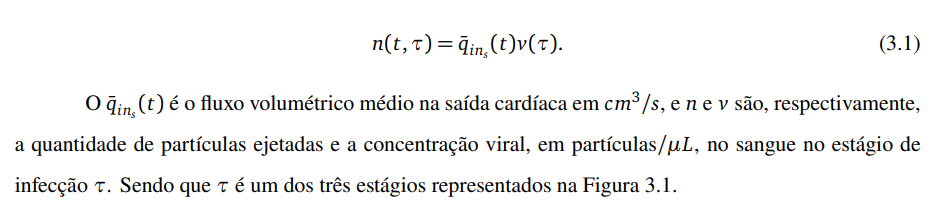

Para a análise da carga viral recebida pelo feto nas distintas fases de gravidez foram escolhidos os momentos de início da infecção, em que a população viral está com a derivada positiva (E1), de saturação da população (E2) e aquele quando seu decaimento chegou a 20% do cume atingido (E3).


Figura da dissertação:

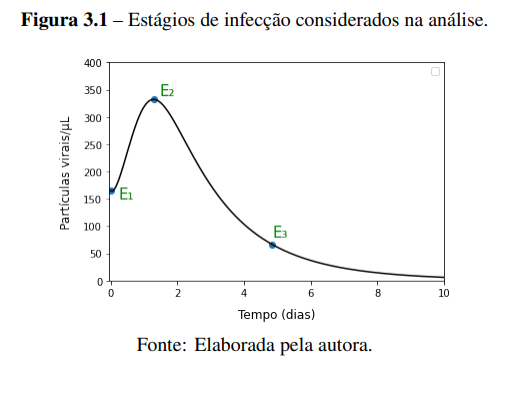

##Código e figura gerada:

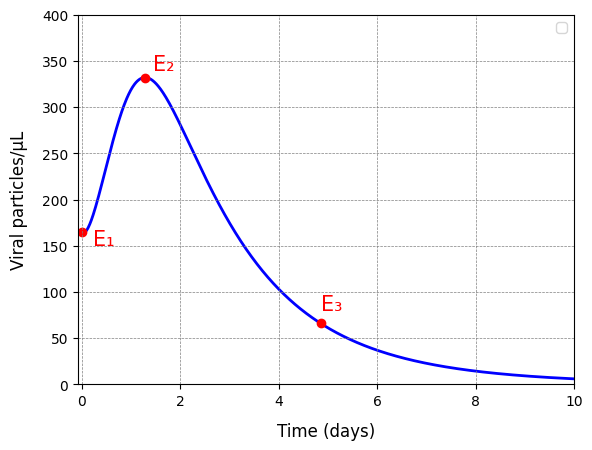

In [ ]:
from matplotlib import lines
fig, ax = plt.subplots()

#ax.plot([t[128],0],[t[128],332])
lgd = []
#lgd.append(lines.Line2D([0,0],[0,332], color = 'blue', label = 'Vertical line'))
plt.legend(handles = lgd)
#plt.title('População de vírus Zika')
plt.xlabel('Time (days)', fontsize = 12, labelpad = 10)      #legenda do eixo x - tempo
plt.ylabel(u'Viral particles/\u03bcL',  fontsize = 12, labelpad = 10)   #legenda do eixo y - partículas do vírus
plt.plot(t,v[0,:,0], color='b',label = 'Pré-gravidez', linewidth = '2', zorder = 1)
plt.annotate('E\u2081',[t[23],150], color='r', size=15)   #legenda do ponto E1
plt.annotate('E\u2082',[t[145],340], color='r', size=15)  #legenda do ponto E2
plt.annotate('E\u2083',[t[485],80], color='r', size=15)   #legenda do ponto E3
plt.scatter([t[0],t[128],t[485]],[165,332,66], color = 'r')                #pontos no gráfico
plt.xlim([-0.08, 10])  #limita eixo x
plt.ylim([0, 400])     #limita eixo y
#plt.plot(t,v[1,:,0],'tab:orange',label='8 semanas')
#plt.plot(t,v[2,:,0],'tab:green',label='16 semanas')
#plt.plot(t,v[3,:,0],'tab:red',label='24 semanas')
#leg = ax.legend();
#plt.grid()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()



# Simulações da propagação de partículas na rede arterial de uma gestante

As partículas consideradas, os exossomos, são
vesículas extracelulares que são utilizadas na comunicação materno-placentária em um cenário saudável que durante uma viremia, como em uma infecção por Zika, servem também de transportadores
do material genético viral.

No primeiro momento, são feitas simulações para $n_0 = 10^3$ partículas ejetadas pelo coração em cada uma das três fases de gravidez, para assim analisar o efeito da variabilidade do canal na informação transmitida

passo $∆t = 10^{−1}$
s, uma velocidade transversal constante $V = 10^{−2}$
cm/s e um coeficiente de difusão $D = 10^{−2} cm^2/s$

## Fig 4.1 -  Atraso da primeira partícula a alcançar o local-alvo em diferentes estágios da gravidez.


Dissertação:

O tempo gasto até que a primeira partícula chegue ao fim da artéria ilíaca interna:

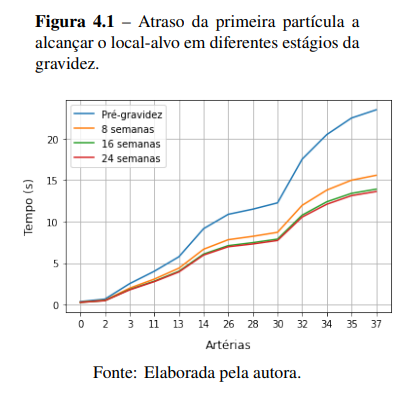

Código:

##Fig 4.2 - Atraso das partículas no percurso coração-placenta em diferentes estágios da gravidez.

Dissertação:

Atraso total de propagação que corresponde ao tempo para que todas as moléculas que não foram absorvidas ou redirecionadas a outros percursos percorressem o percurso desde a aorta ascendente até a ilíaca interna.

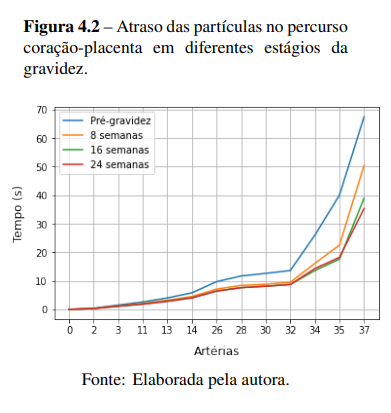

Código:

Na segunda etapa, o sinal de entrada varia segundo o estágio de infecção e a fase de gravidez
em que o organismo se encontra

##Fig 4.3 - Ganho do sistema no percurso coração-placenta para cada período de gestação.

###Dissertação:

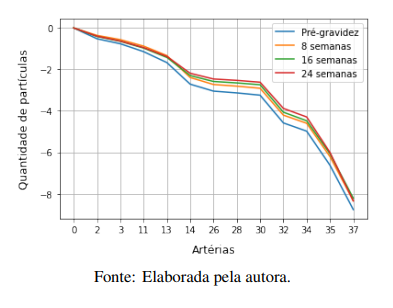

###Código:

##Fig 4.4 – Progressão da concentração de moléculas na artéria ilíaca em cada período de gestação.

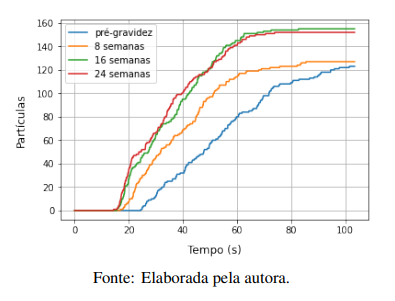

Código:

##Fig 4.5 - Dinâmica populacional durante uma infecção por vírus Zika para cada estágio de gravidez

###A

Dissertação:

Na Figura 4.5a, é apresentado o comportamento da população dos monócitos saudáveis em cada
período de gestação. As curvas se encontram deslocadas verticalmente umas das outras principalmente
por conta da diferença entre seus valores iniciais, uma vez que durante a gravidez ocorre uma monocitose,
ou seja, um aumento na quantidade de monócitos para que o corpo da mulher não rejeite o feto.


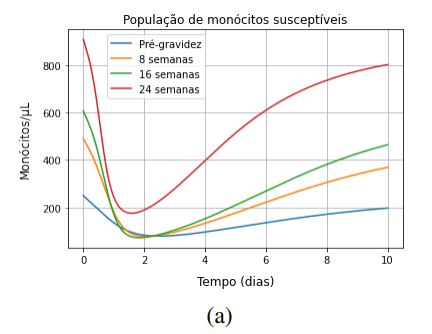

Código:

[link zoom region insert](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/zoom_inset_axes.html#sphx-glr-gallery-subplots-axes-and-figures-zoom-inset-axes-py)

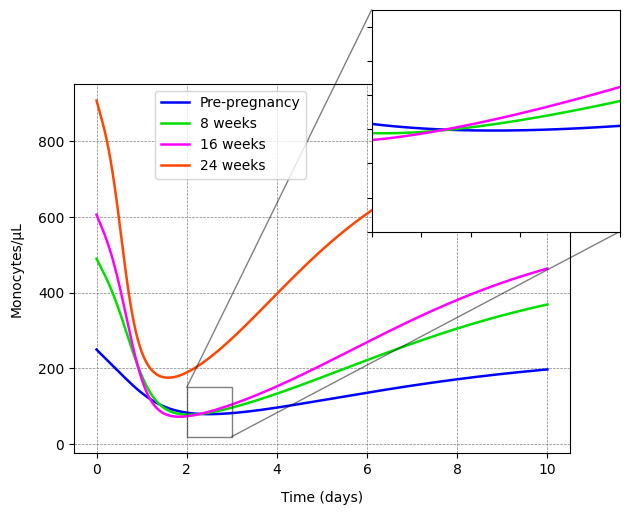

In [ ]:
fig, ax = plt.subplots()
#plt.title('Susceptible monocyte population')
plt.xlabel('Time (days)', fontsize = 10, labelpad = 10)
plt.ylabel(u'Monocytes/\u03bcL',  fontsize = 10, labelpad = 10)
plt.plot(t,s[0,:,0],'#0000ff',label = 'Pre-pregnancy',linewidth = '1.8')
plt.plot(t,s[1,:,0],'#00df00',label='8 weeks',linewidth = '1.8')
plt.plot(t,s[2,:,0],'#ff00ff',label='16 weeks',linewidth = '1.8')
plt.plot(t,s[3,:,0],'#ff4500',label='24 weeks',linewidth = '1.8')
leg = ax.legend(loc='upper left',bbox_to_anchor=(0.15, 1.0));

x1, x2, y1, y2 = 2, 3, 20, 150  # subregion of the original image

axins = ax.inset_axes(
    [0.6, 0.6, 0.5, 0.6], #position set
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

# axins.plot(t,s[0,:,0])
# axins.plot(t,s[1,:,0])
# axins.plot(t,s[2,:,0])
# axins.plot(t,s[3,:,0])
axins.plot(t,s[0,:,0],'#0000ff',linewidth = '1.8')
axins.plot(t,s[1,:,0],'#00df00',linewidth = '1.8')
axins.plot(t,s[2,:,0],'#ff00ff',linewidth = '1.8')
axins.plot(t,s[3,:,0],'#ff4500',linewidth = '1.8')
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

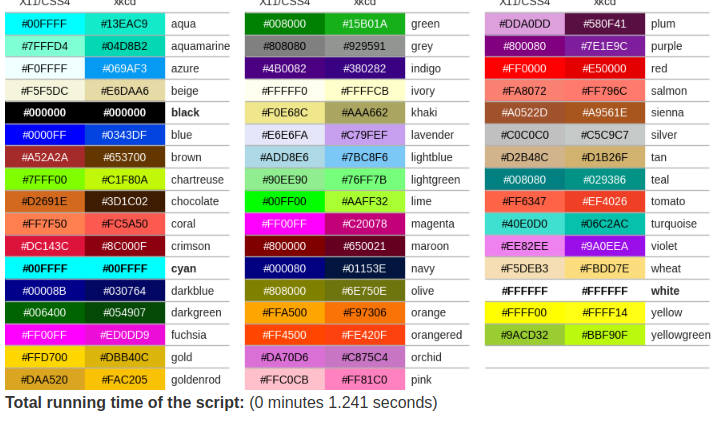

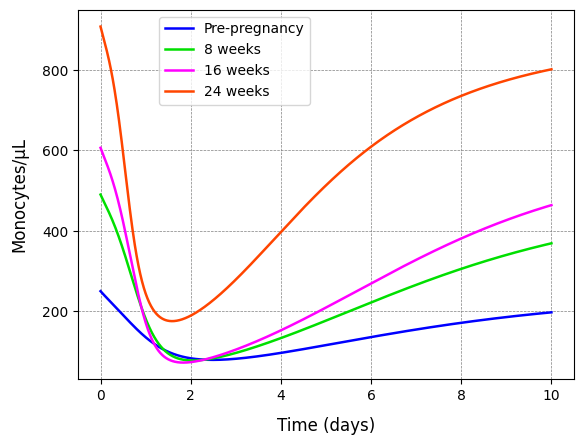

In [ ]:
fig, ax = plt.subplots()
#plt.title('Susceptible monocyte population')
plt.xlabel('Time (days)', fontsize = 12, labelpad = 10)
plt.ylabel(u'Monocytes/\u03bcL',  fontsize = 12, labelpad = 10)
plt.plot(t,s[0,:,0],'#0000ff',label = 'Pre-pregnancy',linewidth = '1.8')
plt.plot(t,s[1,:,0],'#00df00',label='8 weeks',linewidth = '1.8')
plt.plot(t,s[2,:,0],'#ff00ff',label='16 weeks',linewidth = '1.8')
plt.plot(t,s[3,:,0],'#ff4500',label='24 weeks',linewidth = '1.8')
leg = ax.legend(loc='upper left',bbox_to_anchor=(0.15, 1.0));
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

###B

Com a progressão da infecção, a quantidade de monócitos susceptíveis ao vírus decai
significativamente já que há uma migração de monócitos dessa população para a população de infectados
(Figura 4.5b).

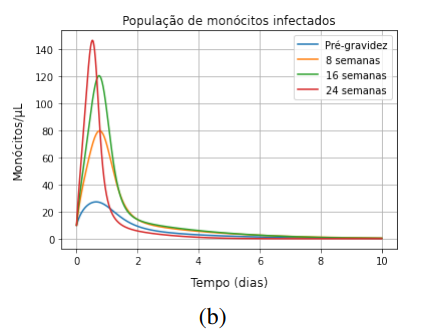

In [ ]:
# (s[3,0,0] - min(s[3,:,0]))/s[3,0,0]
# (s[2,0,0] - min(s[2,:,0]))/s[2,0,0]
# (s[1,0,0] - min(s[1,:,0]))/s[1,0,0]
# (s[0,0,0] - min(s[0,:,0]))/s[0,0,0]

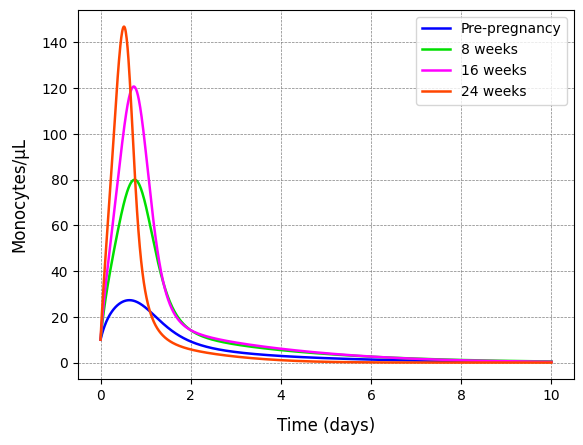

In [ ]:
fig, ax = plt.subplots()
#plt.title('Population of infected monocytes')
plt.xlabel('Time (days)', fontsize = 12, labelpad = 10)
plt.ylabel(u'Monocytes/\u03bcL',  fontsize = 12, labelpad = 10)
plt.plot(t,i[0,:,0],'#0000ff',label = 'Pre-pregnancy',linewidth = '1.8')
plt.plot(t,i[1,:,0],'#00df00',label='8 weeks',linewidth = '1.8')
plt.plot(t,i[2,:,0],'#ff00ff',label='16 weeks',linewidth = '1.8')
plt.plot(t,i[3,:,0],'#ff4500',label='24 weeks',linewidth = '1.8')
leg = ax.legend();
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

###C

População do vírus zika considerando a ação dos monócitos.

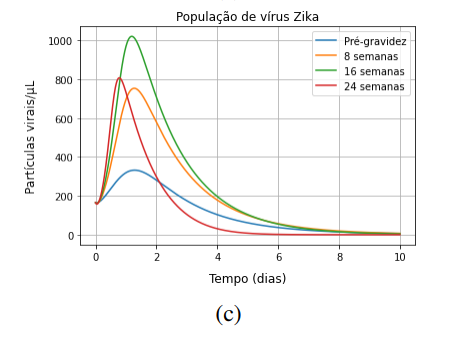

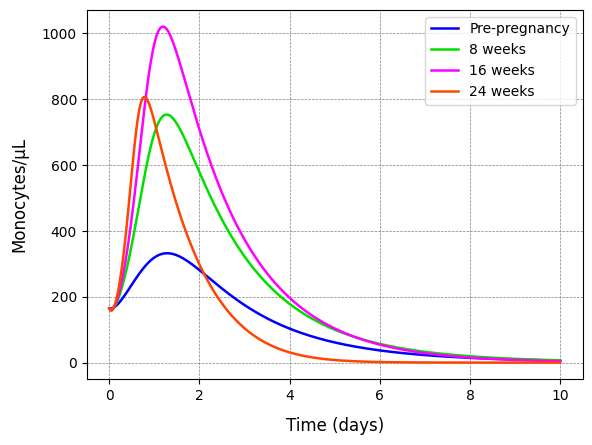

In [ ]:
fig, ax = plt.subplots()
#plt.title('Zika virus population')
plt.xlabel('Time (days)', fontsize = 12, labelpad = 10)
plt.ylabel(u'Monocytes/\u03bcL',  fontsize = 12, labelpad = 10)
plt.plot(t,v[0,:,0],'#0000ff',label = 'Pre-pregnancy',linewidth = '1.8')
plt.plot(t,v[1,:,0],'#00df00',label='8 weeks',linewidth = '1.8')
plt.plot(t,v[2,:,0],'#ff00ff',label='16 weeks',linewidth = '1.8')
plt.plot(t,v[3,:,0],'#ff4500',label='24 weeks',linewidth = '1.8')
leg = ax.legend();
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

###D

Crescimento da população de linfócitos-T

Linfócitos T ou células T são células do sistema imunológico e também um grupo de glóbulos brancos (leucócitos) responsáveis pela defesa do organismo contra agentes desconhecidos (antígenos). Seu papel principal é como imunidade específica e imunidade celular, induzindo a Apoptose(autodestruição) de células invadidas por vírus, bactérias intracelulares, danificadas ou cancerígenas. Se diferenciam de acordo com sua função em: citotóxicas (CD8), auxiliares (CD4), natural killer (NKT), memória(CD45), reguladoras (FOXP3) ou gama-delta (γδ). Amadurecem no timo, por isso se chamam linfócitos T.


Logo no início da viremia, a população cresce rapidamente, mas quanto mais cedo ocorre a resposta imune (Figura 4.5d), mais abrupto é o decaimento da população.

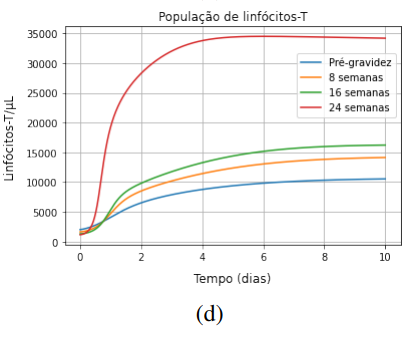

In [ ]:
list(v[0,:,0]).index(max(v[0,:,0]))

128

In [ ]:
def integral(vetor, passo):
  soma = 0
  for elemento in vetor:
    soma = soma + elemento*passo

  return soma


In [ ]:
def get_decrease(vector):
  _max = max(vector)
  index = vector.index(_max)
  for element in vector[index:]:
    if element <= 0.2 * _max:
      return element, vector.index(element)
  return "Invalid"

In [ ]:
max_values = np.zeros(len(wks_s))
fall_values = np.zeros(len(wks_s))
fall_indexes = np.zeros(len(wks_s))

for w in range(len(wks_s)):
  max_values[w] = max(v[w,:,0])
  #print(max(v[w,:,0]))
  fall_values[w], fall_indexes[w] = get_decrease(list(v[w,:,0]))
  #print('\n')


In [ ]:
Q = np.array([39.74576, 47.916753, 52.4561, 53.93897])
npart_init = Q * 165000
#npart_init
npart_max = max_values * Q * 1000
#npart_max
npart_fall = fall_values * Q * 1000
#npart_fall

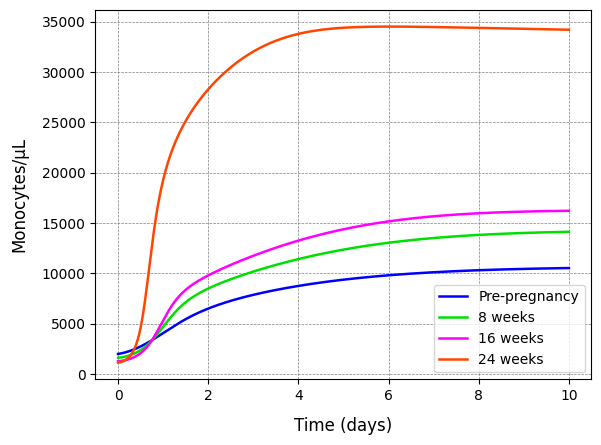

In [ ]:
fig, ax = plt.subplots()
#plt.title('T-lymphocyte population')
plt.xlabel('Time (days)', fontsize = 12, labelpad = 10)
plt.ylabel(u'Monocytes/\u03bcL',  fontsize = 12, labelpad = 10)
plt.plot(t,z[0,:,0],'#0000ff',label = 'Pre-pregnancy',linewidth = '1.8')
plt.plot(t,z[1,:,0],'#00df00',label='8 weeks',linewidth = '1.8')
plt.plot(t,z[2,:,0],'#ff00ff',label='16 weeks',linewidth = '1.8')
plt.plot(t,z[3,:,0],'#ff4500',label='24 weeks',linewidth = '1.8')
leg = ax.legend();
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

##Fig 4.6 - Taxa de variação r da população viral.


Dissertação:

Pode-se analisar a variação da população viral a partir da primeira derivada dessa população, a taxa r.

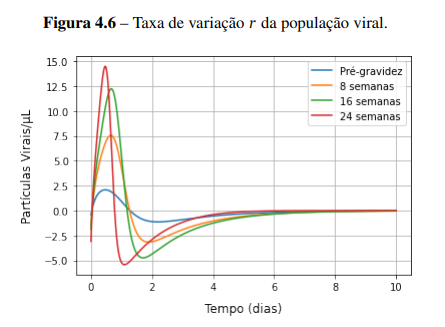

Código:

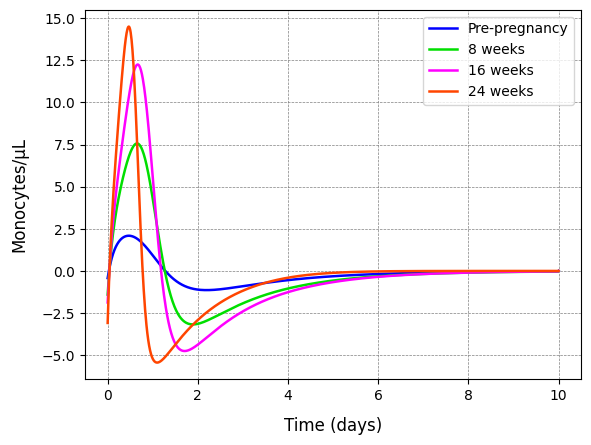

In [ ]:
fig, ax = plt.subplots()
# fig.set_facecolor("k")
# ax.set_facecolor("#A9C2D5")
#plt.title('Virus population derivative')
plt.xlabel('Time (days)', fontsize = 12, labelpad = 10, color = 'k')
plt.ylabel(u'Monocytes/\u03bcL',  fontsize = 12, labelpad = 10, color = 'k')
plt.plot(t,incremento_v[0,:],'#0000ff',label = 'Pre-pregnancy',linewidth = '1.8')
plt.plot(t,incremento_v[1,:],'#00df00',label='8 weeks',linewidth = '1.8')
plt.plot(t,incremento_v[2,:],'#ff00ff',label='16 weeks',linewidth = '1.8')
plt.plot(t,incremento_v[3,:],'#ff4500',label='24 weeks',linewidth = '1.8')
leg = ax.legend();
# ax.tick_params(axis='x', colors='w')
# ax.tick_params(axis='y', colors='w')

# ax.spines['left'].set_color('w')
# ax.spines['top'].set_color('w')
# ax.spines['right'].set_color('w')
# ax.spines['bottom'].set_color('w')

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

##Fig 4.7 -  Recepção das partículas virais na placenta para cada período de gestação nos 3 estágios de infecção

Dissertação

###A) E1 - Início da infecção

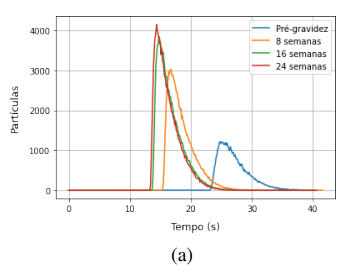

###B) E2 - Momento de máxima carga viral

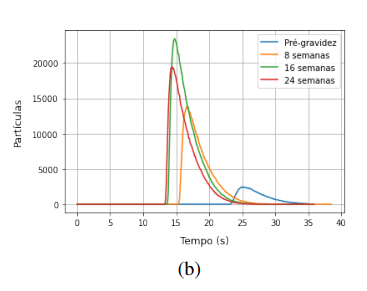

###C) E3 - Atenuação de 80% da máxima carga viral

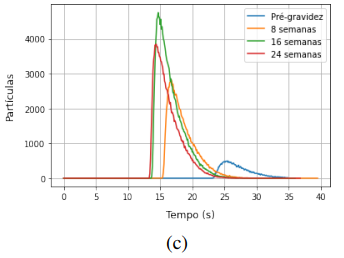

Código:

In [ ]:
# plt.figure(figsize=(6,4), layout='constrained')
# plt.plot(pd.concat([pd.Series(0),e1_s0_plot.loc[:]]), label='Pré-gravidez')
# plt.plot(pd.concat([pd.Series(0),e1_s1_plot.loc[:]]), label='8 semanas')
# plt.plot(pd.concat([pd.Series(0),e1_s2_plot.loc[:]]), label='16 semanas')
# plt.plot(pd.concat([pd.Series(0),e1_s3_plot.loc[:]]), label='24 semanas')
# plt.xticks(np.arange(0, 50, 10))
# plt.xlabel('Tempo (s)')
# plt.ylabel('Partículas')
# plt.grid(True)
# plt.legend()

In [ ]:
# plt.figure(figsize=(6, 4), layout='constrained')
# plt.plot(pd.concat([pd.Series(0),e2_s0_plot.loc[:]]), label='Pré-gravidez')
# plt.plot(pd.concat([pd.Series(0),e2_s1_plot.loc[:]]), label='8 semanas')
# plt.plot(pd.concat([pd.Series(0),e2_s2_plot.loc[:]]), label='16 semanas')
# plt.plot(pd.concat([pd.Series(0),e2_s3_plot.loc[:]]), label='24 semanas')
# plt.xticks(np.arange(0, 50, 5))
# plt.xlabel('Tempo (s)')
# plt.ylabel('Partículas')
# plt.grid(True)
# plt.legend()

In [ ]:
# plt.figure(figsize=(6, 4), layout='constrained')
# plt.plot(pd.concat([pd.Series(0),e3_s0_plot.loc[:]]), label='Pré-gravidez')
# plt.plot(pd.concat([pd.Series(0),e3_s1_plot.loc[:]]), label='8 semanas')
# plt.plot(pd.concat([pd.Series(0),e3_s2_plot.loc[:]]), label='16 semanas')
# plt.plot(pd.concat([pd.Series(0),e3_s3_plot.loc[:]]), label='24 semanas')
# plt.xticks(np.arange(0, 50, 5))
# plt.xlabel('Tempo (s)')
# plt.ylabel('Partículas')
# plt.grid(True)
# plt.legend()

##Fig 4.8 - Acúmulo de vírus na placenta ao fim de 24 horas para cada período de gestação nos 3 estágios de infecção

Pode-se fazer a análise do impacto do acúmulo de vírus na placenta
ao longo do tempo

Dissertação:

###A) E1 - Início

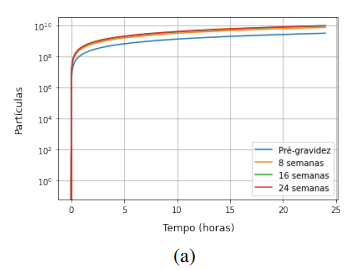

###B) E2 - Cume


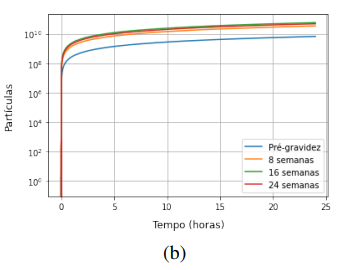

###C) E3 - Queda acentuada


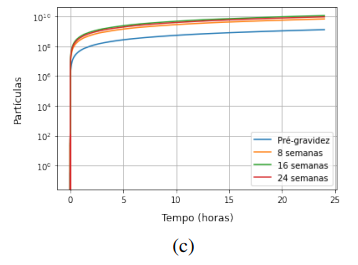

Código:

#Modelo parte 2

## Bibliotecas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from scipy.interpolate import CubicSpline, UnivariateSpline                 #tentativa spline
from scipy.signal import savgol_filter                                      #tentativa spline
import scipy.integrate as integrate
import scipy.special as special
import random as rd
import pandas as pd


## Funções

In [ ]:
#RAIO DE UMA ARTÉRIA GRANDE - descrito em Chahibi
def getRatio(rtop,rbot,lart,l):   #Recebe raios superior e inferior, comprimento da artéria e coordenada em que se quer o raio
  k =  np.log((rtop/rbot))/lart   #Fator cônico para uma artéria grande
  r =  (rtop * np.exp(- k * l) )  #Raio cônico
  return r

In [ ]:
#DISTÂNCIA TOTAL ATÉ UMA ARTÉRIA
def getDistance(arteria,array_pai,array_l):         #Recebe index da artéria, array de pais e de comprimentos
  if arteria==0:
    d = array_l[arteria]                            #Distância acumulada na primeira artéria é seu comprimento
  else:
    d = getDistance(array_pai[arteria], array_pai, array_l)+array_l[arteria] #Distância acumulada = l acumulado do pai + l da artéria
  return d

In [ ]:
#IMPEDÂNCIAS DAS ARTÉRIAS PEQUENAS - descrito em Chahibi
#Aqui se dá a construção de uma rede de artérias pequenas que parte da última artéria grande de um ramo (interface com as pequenas),
# para descobrir a impedância na saída dessa artéria I. O cálculo das impedâncias é um processo de baixo para cima.

def getImpedance(rl,mu,rho,k1,k2,k3,size_v):    #Recebe raio da artéria I da interface, parâmetros e tamanho do vetor wk

  ########## INICIALIZAÇÃO ##########
  zIn = np.zeros(size_v,dtype=complex)          #Impedância vista na entrada da artéria pequena
  zOut = np.zeros(size_v,dtype=complex)         #Impedância vista na saída da artéria pequena
  argumento = np.zeros(size_v,dtype=complex)    #Argumento da função de Bessel
  razao = np.zeros(size_v,dtype=complex)        #Usada na simplificação da função de Bessel para argumento grande
  tau = np.zeros(size_v,dtype=complex)
  ###################################

  rMin = 0.08                                   #Raio mínimo em cm para truncamento da rede
  alpha = 0.9                                   #Fator para raio das artérias filhas da esquerda
  beta = 0.6                                    #Fator para raio das artérias filhas da direita
  lrr = 50                                      #Relação comprimento/raio para artérias pequenas
  ll = lrr*rl                                   #Comprimento da artéria pequena
  nu = mu/rho                                   #Viscosidade cinemática do sangue - 25.5306 cm²/s
  cl = (np.pi*lrr*rl**2)/(k1*np.exp(-k2*rl)+k3) #Fórmula da compliance extraída de Chahibi e Olufsen, contendo l no numerador

  if (rl >= rMin):                                                     #Constrói rede de artérias pequenas que parte da artéria grande I usando alpha, beta e lrr para determinar os raios e comprimentos, até que alcance o raio mínimo e trunque a rede
    zR = getImpedance(beta*rl,mu,rho,k1,k2,k3,size_v)                #Impedância da filha da direita
    zL = getImpedance(alpha*rl,mu,rho,k1,k2,k3,size_v)               #Impedância da filha da esquerda

    for k in np.arange(size_v):               #Para cada componente de frequência serão calculadas as imp na saída e na entrada da artéria pequena
      if(zR[k] != 0 and zL[k] != 0):          #Quando filhos tiverem impedância na entrada diferente de 0, Zeq é o paralelo das filhas
        zOut[k] = 1/(1/zR[k] + 1/zL[k])
      else:                                   #Caso contrário, Zeq das filhas é 0
        zOut[k] = 0

      argumento[k] = (1j*rl**2*np.abs(wk[k]))/nu                     #A função de Bessel (Jv) de ordem v é par, por isso usamos o módulo de wk
                                                                      # para um argumento puramente imaginário, as soluções para a equação de Bessel são as funções de Bessel modificadas (Iv)
      if(k == 1000):
        zIn[1000] = (8*mu*ll)/(np.pi*rl**4) + zOut[1000]               #Componente DC (wk->0). Equivalente ao R (resistência) das artérias grandes
      elif(k>=980 and k<=1020):                                        #Para esses valores de k, o argumento é pequeno e a função J converge
        tau[k] = (lrr/np.sqrt(np.pi))*np.sqrt((rho*cl)/(1-((2*special.jv(1,argumento[k]))/(argumento[k]*(special.jv(0,argumento[k]))))))
        zIn[k] = ((1j*tau[k]*np.sin(tau[k]))/(ll) + zOut[k]*np.cos(tau[k]))/(np.cos(tau[k]) + (1j*ll*zOut[k]*np.sin(tau[k]))/(tau[k]))    #zIn e zOut se relacionam dessa maneira
      else:                                                          #Para argumento>>1, não converge, então foi feita uma simplificação
        razao[k] = 1j*np.exp(-1/(2*argumento[k].imag))               #j*Expansão assintótica para a razão I1/I0, porque J1/J0 = jI1/I0
        tau[k] = (lrr/np.sqrt(np.pi))*np.sqrt((rho*cl)/(1-(2*razao[k])/(argumento[k])))
        zIn[k] = ((1j*tau[k]*np.sin(tau[k]))/(ll) + zOut[k]*np.cos(tau[k]))/(np.cos(tau[k]) + (1j*ll*zOut[k]*np.sin(tau[k]))/(tau[k]))

  return zIn  #A impedância de entrada da primeira artéria pequena da rede = impedância de saída da artéria grande I


## Parâmetros

## Geral

In [ ]:
#SEGUINDO O SISTEMA DE UNIDADES CGS

########## EXTRAÍDO DE CHAHIBI: INÍCIO ##########
mi = 49e-3                                #viscosidade dinâmica sanguinea - g/cm.s
rho = 1.055                               #densidade sanguinea - g/cm³
ni = mi/rho                               #viscosidade cinemática - 0.0464


#PARA CÁLCULO DA COMPLIANCE DAS ARTÉRIAS
k1 = 2.01e7                               #constante fornecida no artigo - g/(s².cm) - 1.34e7 (em Olufsen, antes de multiplicar por 3/2)
k2 = 22.53                                #constante fornecida no artigo - cm⁻¹
k3 = 8.655e5                              #constante fornecida no artigo - g/(s².cm) - 5.77e5 (em Olufsen, antes de multiplicar por 3/2)

#ARTÉRIAS GRANDES - parâmetros sem arteriosclerose
r_top_saud = np.array([1.525, 0.35, 1.502, 1.42, 0.95, 0.425, 0.525, 0.2, 0.407, 0.175, 0.175, 1.342, 0.525, 1.246, 1.124, 0.63, 0.425, 0.2, 0.407, 0.175, 0.175, 0.35, 0.3, 0.275, 0.175, 0.2, 0.924, 0.4, 0.838, 0.275, 0.814, 0.275, 0.792, 0.2, 0.627, 0.4, 0.37, 0.2, 0.2, 0.314]) #raio inicial
r_bot_saud = np.array([1.502, 0.3, 1.42, 1.342, 0.7, 0.407, 0.4, 0.2, 0.25, 0.175, 0.175, 1.246, 0.4, 1.124, 0.924, 0.5, 0.407, 0.2, 0.25, 0.175, 0.175, 0.3, 0.25, 0.25, 0.15, 0.2, 0.838, 0.35, 0.814, 0.275, 0.792, 0.275, 0.627, 0.175, 0.55, 0.37, 0.314, 0.2, 0.2, 0.2]) #raio final
artLength_saud = np.array([1, 10, 3, 3, 3.5, 3.5, 16.75, 13.5, 39.75, 22, 22.25, 4, 19.25, 5.5, 10.5, 7.25, 3.5, 13.5, 39.75, 22.25, 22, 2, 2, 6.5, 5.75, 5.5, 5.25, 5, 1.5, 3, 1.5, 3, 12.5, 3.75, 8, 5.75, 14.5, 4.5, 11.25, 44.25]) #comprimento em cm
filho = [[1, 2], [], [3, 4], [11, 12], [5, 6], [7, 8], [], [], [9, 10], [], [], [13, 16], [], [14, 15], [21, 26], [], [17, 18], [], [19, 20], [], [], [22, 23], [25, 24], [], [], [], [27, 28], [], [29, 30], [], [31, 32], [], [33, 34], [], [35, 35], [36, 37], [38, 39], [], [], []]
pai = [-1, 0, 0, 2, 2, 4, 4, 5, 5, 8, 8, 3, 3, 11, 13, 13, 11, 16, 16, 18, 18, 14, 21, 21, 22, 22, 14, 26, 26, 28, 28, 30, 30, 32, 32, 34, 35, 35, 36, 36]
irmao = [-1, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 16, 15, 14, 13, 18, 17, 20, 19, 26, 23, 22, 25, 24, 21, 28, 27, 30, 29, 32, 31, 34, 33, 35, 37, 36, 39, 38]
########## EXTRAÍDO DE CHAHIBI: FIM ##########

print(f'tamanho de r_top_saud: {len(r_top_saud)}, \ntamanho de r_bot_saud: {len(r_bot_saud)}, \ntamanho de artLength_saud: {len(artLength_saud)}')

#PARA CÁLCULO DA DIFUSÃO DA PARTÍCULA
Kb = 1.38064852e-16                       #Constante de Boltzmann - cm².g/s².K
Tp = 309.5                                #Temperatura do sangue - 36.5°C em K
#Tp = 314.0, se 315: mi=30e-3
#Tp = 307.0, se 310: mi=40e-3
a = 40e-7                                #Raio da partícula - zyca virus(cm) - ref [9] do relatorio final meninas
#a = 90e-7                                 #Raio da partícula - HIV (cm)
#mii = 0.0836                              #viscosidade dinâmica feita a proporção pra HIV
mii = 0.0668                             #viscosidade dinâmica feita a proporção pra Zika

#COEFICIENTE DE DIFUSÃO
Dif = Kb * Tp / (6 * np.pi * mi * a)     #Fórmula em Chahibi - cm²/s
print(f'Dif: {Dif}, \nni/Dif: {ni/Dif}')

#TEMPO
N = 2001                                   #Número de amostras
tempos, passo = np.linspace(start = 0.0, stop = 1.0, num = N, retstep = True)
print(f'tempos: {tempos}, \ntamanho de tempos: {len(tempos)}, \npasso: {passo}')


#FREQUÊNCIA
wk = 2*np.pi*fftshift(fftfreq(N,passo))
print(f'wk: {wk}, \ntamanho de wk: {len(wk)}')

#TRIMESTRES DE GRAVIDEZ
semanas= np.array([0, 8, 16, 24])
mudanca_f = np.array([1, 1.0461, 1.1077, 1,1231]) #fatores que multiplicam a frequência do batimento, modificando-a para cada semana (extraído do trabalho das meninas)
mudanca_amp = np.array([1, 1.238, 1.4047, 1.3571])   #fatores que multiplicam Qin, modificando sua amplitude para cada semana (extraído do trabalho das meninas)
mudanca_res = np.array([1, 0.7042, 0.6730, 0.6759])

#CAMINHOS
# caminho2=[0,11,28,33]                             #Art1,12,29 e 34
# nome_art = ['Ascending Aorta','Aortic Arch','Abdominal Aorta','Mesenteric'] #Artéria mesentérica fica na região do útero
# caminho=[0,2,3,11,13,14,26,28,30,32,33]           #Todas as artérias no caminho até a placenta
rota = [0,2,3,11,13,14,26,28,30,32,34,35,37]
"""
Mais a frente do codigo analisado da pesquisa, define-se a variavel 'rota' com mais arterias que 'caminho'.
Pelo nao entendimento da diferenca entre ambas as variaveis, para efeito de analise, vou considerar caminho = rota.
"""
caminho = rota


tamanho de r_top_saud: 40, 
tamanho de r_bot_saud: 40, 
tamanho de artLength_saud: 40
Dif: 1.1566090618561683e-08, 
ni/Dif: 4015660.8798995866
tempos: [0.000e+00 5.000e-04 1.000e-03 ... 9.990e-01 9.995e-01 1.000e+00], 
tamanho de tempos: 2001, 
passo: 0.0005
wk: [-6280.04528454 -6273.76523925 -6267.48519397 ...  6267.48519397
  6273.76523925  6280.04528454], 
tamanho de wk: 2001


In [ ]:
"""
No codigo em analise ha o tratamento para os efeitos de arteriosclerose sobre os parametros das arterias saudaveis.
Como nao encontrei mencao na dissertacao a respeito de arteriosclerose, estou considerando para fins de analise
os parametros de arterias saudaveis para os calculos em steps subsequentes que serao insumos para plotagens de resultados.
"""
r_top = r_top_saud
r_bot = r_bot_saud
artLength = artLength_saud

## Qin

In [ ]:
Qin = np.zeros((len(semanas),len(tempos))) #inicialização de qin(t)
QinW = np.zeros(Qin.shape, dtype = complex) #inicialização de Qin(W)

In [ ]:
#ALTERNATIVA 1 - FUNÇÃO REPRESENTANDO UM PERÍODO CARDÍACO ESTIMADA PELO PROF LEO
omega = 238**(1/2)
Qin_Leo = (6000 * omega * np.exp(- 8 * tempos) * np.sin( omega * tempos)) / 119

#ALTERNATIVA 2 - AMOSTRAS NÃO REGULARMENTE ESPAÇADAS NO TEMPO EXTRAÍDAS DO DOCUMENTO DE ENTRADA DO SOFTWARE VAMPY
Qin_tempos_noregular = [0.0, 0.011278907456574228, 0.022301620768042818, 0.028326161347979273, 0.03535797456053588, 0.03836706231454007, 0.042377057629236325, 0.049351585194440134, 0.05431793256633177, 0.059271549794367245, 0.0632051642459264, 0.07105966300518857, 0.0768932514272824, 0.08275230013708854, 0.0885731584153262, 0.09239220157217976, 0.09723124750550963, 0.09911849133218811, 0.10198754750377434, 0.10386842625852469, 0.10671838721432667, 0.1095747132420567, 0.11241194405400254, 0.11524917486594832, 0.11806731046210983, 0.11990363371336354, 0.12174632203654545, 0.12458991792041929, 0.1264326062436011, 0.1292571069116908, 0.1310807000190884, 0.13393066097489031, 0.13481063216894867, 0.13667241570791477, 0.13949055130407628, 0.14135233484304238, 0.14419593072691628, 0.14702679646693395, 0.14986402727887976, 0.15471580335606583, 0.15759758967150822, 0.1595484842174676, 0.1625130164679751, 0.16749209398372294, 0.1685057316882712, 0.17252209207489555, 0.17760301074149276, 0.1817021170631823, 0.18583304874451217, 0.1879748954483142, 0.19011674215211627, 0.1932531313446823, 0.1953822479046281, 0.197511364464574, 0.20065411872906808, 0.20178869280024997, 0.2049441772086002, 0.20707329376854605, 0.21020968296111203, 0.2123324344491298, 0.21444882086521955, 0.21659066756902157, 0.21970159647387522, 0.22182434796189293, 0.22494164193867466, 0.22808439620316867, 0.2311889600360943, 0.23430625401287597, 0.23741081784580154, 0.24152265431134723, 0.24560903048918054, 0.25068994915577775, 0.25573267739080646, 0.2607690405539071, 0.2677626633348952, 0.2747499210439551, 0.28367534315511833, 0.29256257483471304, 0.2994734516806359, 0.306390693598487, 0.3153033855657939, 0.3262369878702693, 0.3382160532389332, 0.3472369514290177, 0.3563024051225988, 0.362371501206032, 0.3704615076266333, 0.37554879136515873, 0.38363243271383207, 0.389688798653409, 0.3937306193277458, 0.3987669824908463, 0.4037842504381628, 0.40975787044267453, 0.4167005726482379, 0.42360508442223266, 0.42948322834782315, 0.43633681954639325, 0.4421895031842713, 0.44703491418952934, 0.4538566800284589, 0.4606848109393168, 0.4665438596491229, 0.47139563572630905, 0.47727377965189943, 0.4821510160167979, 0.4870282523816962, 0.4939263990837629, 0.5008309108577578, 0.5067727055026292, 0.5137217727801205, 0.5196953927846324, 0.5276708279105282, 0.5336762732746804, 0.5406953563433808, 0.5467198969233174, 0.554752617696566, 0.5607771582765024, 0.5698044215385151, 0.5788444149443838, 0.5898798583997086, 0.5999143942943413, 0.6069334773630417, 0.6149216426327937, 0.6249116230239299, 0.6388606781543376, 0.6527715428531766, 0.6647060527183439, 0.6776351050722753, 0.6895377895778022, 0.7004586617384214, 0.7133749839484965, 0.7282867562080276, 0.7472085237822551, 0.7641221111631702, 0.7849884082114289, 0.798912003054124, 0.813817410241727, 0.8307182674787862, 0.8456173095944611, 0.8585590920922486, 0.8695308848282923, 0.8844426570878237, 0.893380809342843, 0.9013307841810265, 0.917]
Qin_Amostras_noregular = [4.1, 3.6980234959307268, 3.2839467610668613, 2.996997934995747, 2.6462248598747102, 2.5187498915438944, 2.3594495635726283, 2.2966664931368967, 2.329533031391538, 2.42639734846513, 2.651083693407603, 3.1644541621115074, 3.8374720183247426, 4.382494316900061, 5.119509951932251, 5.9201763062453345, 6.593020632689534, 7.105349922779251, 7.681850521456955, 8.226178700956147, 8.898675967862285, 9.539174345358942, 10.27566939108404, 11.012164436809133, 11.844656150762662, 12.612976556128201, 13.349298072084265, 14.05379422839988, 14.790115744355942, 15.590608568899992, 16.42292675308449, 17.095424019990627, 17.671577559130267, 18.311902406857893, 19.14439412081142, 19.78471896853905, 20.489215124854667, 21.25770905998924, 21.99420410571433, 22.603050653339576, 23.115553473198325, 23.307893869193258, 23.404411126728785, 23.373279886164468, 23.277456747705067, 23.086157530324325, 22.543044059208352, 21.935759279504396, 21.168480052753047, 20.400853766463634, 19.63322748017422, 18.86577472365384, 18.162146216183384, 17.458517708712925, 16.65906606278307, 15.95526402554358, 15.091814600794763, 14.388186093324308, 13.620733336803927, 12.949103718742947, 12.309472990091447, 11.541846703802037, 10.902389504919567, 10.23075988685859, 9.55930379856664, 8.759852152636782, 8.152393843163793, 7.480937754871846, 6.8734794453988535, 6.202196886875942, 5.658909885990941, 5.115796414874975, 4.764676280215873, 4.445555034966247, 4.286775296302078, 4.159994447047392, 4.28955177260659, 4.611102434622659, 4.868308258281708, 5.0935151925312745, 5.287070296909434, 5.320978013778262, 5.099068145140297, 4.748642129557322, 4.174223888108006, 3.663282836170545, 2.99269439672376, 2.417582036198308, 1.7789924861610018, 1.3320492130424952, 1.0127544380238476, 0.6936331927742216, 0.47050861575303315, 0.43955090495774485, 0.536762281569402, 0.8259669946379269, 1.2749926249848151, 1.8201884533291697, 2.3972096413139674, 3.038055078348691, 3.743245353740434, 4.416436739722698, 4.96145903829802, 5.570305585923265, 6.0193312162701496, 6.500182206257481, 6.981033196244816, 7.302236798722824, 7.5914415117913485, 7.720478248043452, 7.78569073524563, 7.754733024450346, 7.660124594374167, 7.469172436531487, 7.182397140229405, 6.895448314158294, 6.512849879396811, 6.225901053325696, 5.843476148333249, 5.397053464521836, 4.918978950839019, 4.472729796796639, 4.18595450049456, 4.027348291599424, 3.8050913634233936, 3.679525222551927, 3.745952418137332, 3.748034775365717, 3.750290662363131, 3.9123674666389014, 4.010272962326685, 4.076526628143057, 4.111128464088015, 3.986429972061707, 3.9573810887257714, 4.057021882103875, 4.0594512988703215, 4.126052024224759, 4.161000919707774, 4.259600534471691, 4.1978586426501465, 4.039773023062104, 4.074374859007062, 4.139934405747308, 4.173321533309039, 4.1]

Qin_Amostras = [] #Criando lista

#INTERPOLAÇÃO DA ALTERNATIVA 2
for t in tempos:
   Qin_Amostras.append(np.interp(t, Qin_tempos_noregular, Qin_Amostras_noregular))
Qin_amostras = np.array(Qin_Amostras) #Transformando tipo lista para tipo numpy

#ESCOLHA DO QIN E FFT
for s in range(len(semanas)):
  Qin[s] = (6000 * omega * np.exp(- 8 * tempos) * np.sin( omega * mudanca_f[s] * tempos)) / 119 #Modifica equação de Leo pra cada semana
  QinW[s] = np.fft.fftshift(np.fft.fft(Qin[s],norm="ortho"))                                    #Transforma qin(t) para Qin(W) e deixa espectro bilateral


## Rede Arterial

In [ ]:
#CARACTERIZAÇÃO DE CADA ARTÉRIA GRANDE partindo da teoria de linhas de transmissão
#PARA CONSTRUIR UMA MATRIZ DE TRANSFERÊNCIA, é necessário ter a imp. característica e o coef. de propagação
#para obter a imp. característica e o coef. de propagação, é necessário ter medidas elétricas R, L, C e G

################ INICIALIZAÇÃO ################
rl = np.zeros(r_top.shape[0])
Rl = np.zeros(r_top.shape[0])
Ll = np.zeros(r_top.shape[0])
Cl = np.zeros(r_top.shape[0])
Gl = np.zeros(r_top.shape[0])
gama = np.zeros((r_top.shape[0],len(wk)),dtype = complex)
Z = np.zeros((r_top.shape[0],len(wk)),dtype = complex)
A = np.zeros((r_top.shape[0],len(wk)),dtype = complex)
B = np.zeros((r_top.shape[0],len(wk)),dtype = complex)
C = np.zeros((r_top.shape[0],len(wk)),dtype = complex)
D = np.zeros((r_top.shape[0],len(wk)),dtype = complex)
Tl = np.zeros([r_top.shape[0],len(wk),2,2],dtype = complex)
###############################################

for i in range(len(artLength)):

  rl[i] =  getRatio(r_top[i], r_bot[i], artLength[i],artLength[i])            #Raio no fim da artéria

  ########## MEDIDAS ELÉTRICAS por un. de comprimento ##########
  Rl[i] = (8 * mi) / (np.pi * rl[i] ** 4)                                     #Resistência
  Ll[i] = (rho) / (np.pi * rl[i] ** 2)                                        #Indutância - segunda lei de Ohm
  Cl[i] = (np.pi * rl[i] ** 2) / (k1 * np.exp(- k2 * rl[i]) + k3)             #Capacitância = compliance das artérias devido à elasticidade
  Gl[i] = 1e-100;                                                             #Admitância, considerada 0

  ############## IMP. CARACT. E COEF. DE PROPAG. ##############
  gama[i] = np.sqrt((Rl[i] + 1j * wk * Ll[i]) * (Gl[i] + 1j * wk * Cl[i]))    #Coef. de propagação de um sinal na artéria
  Z[i] = np.sqrt((Rl[i] + 1j * wk * Ll[i]) / (Gl[i] + 1j * wk * Cl[i]))       #Imp. característica = impedância vista na entrada da artéria se seu l fosse infinito

  ################### MATRIZ DE TRANSFER. T ###################               #teoria de circuitos de 2 portas
  A[i] = np.cosh(gama[i] * artLength[i])                                      #parâmetro t11 - Ganho de tensão (adimensional)
  B[i] = Z[i] * np.sinh(gama[i] * artLength[i])                               #parâmetro t12 - Impedância (ohm)
  C[i] = (1 / Z[i]) * np.sinh(gama[i] * artLength[i])                         #parâmetro t21 - Admitância (mho)
  D[i] = np.cosh(gama[i] * artLength[i])                                      #parâmetro t22 - Ganho de corrente (adimensional)

  for k in range(len(tempos)):
    Tl[i][k] = ( [[A[i,k], B[i,k]], [C[i,k], D[i,k]]])                        #Matriz de transferência T para cada artéria l

In [ ]:
#CÁLCULO DAS IMPEDÂNCIAS NA SAÍDA E NA ENTRADA DE CADA ARTÉRIA l, necessárias para calcular a matriz de transf. de um bloco de artérias

################ INICIALIZAÇÃO ################
ZLout = np.zeros((r_top.shape[0],len(wk)), dtype = complex)
ZL = np.zeros((r_top.shape[0],len(wk)),dtype = complex)
###############################################

for i in range(len(artLength)):
  if(len(filho[i]) == 0):                                                       #Para artérias na interface (sem filhas), Zout=Zin da artéria pequena que a sucede
    ZLout[i] = getImpedance(rl[i],mi,rho,k1,k2,k3,len(wk))                      #Essa função constrói a rede das pequenas e calcula de baixo pra cima as impedâncias
    num = ZLout[i] + Z[i] * np.tanh(gama[i] * artLength[i])
    den = Z[i] + ZLout[i] * np.tanh(gama[i] * artLength[i])
    ZL[i] = Z[i] * num /den                                                     #Impedância na entrada das artérias na interface

for i in range(len(artLength)-2,-1, -1):                                        #Percorre toda a rede das grandes
  if(len(filho[i]) != 0):                                                       #Para artérias com filhas
    # if i == art_art:
    #   ZLout[f] = ( 1/ZL[filho[f][0]]+1/ZL[filho[f][1]] )**(-1)
    #   ZL[f] = Z[f]*((ZLout[f]+(Z[f]*np.tanh(gama[f]*artLength[f])))/(Z[f]+(ZLout[f]*np.tanh(gama[f]*artLength[f]))));
    #   ZLout[i] = ZL[f]                                                          #Na artéria com segmento de arteriosclerose, a imp. de saída é igual à imp. na entrada do segmento, já que esse não tem irmão
    # else:
    """
    Por estar desconsiderando o acometimento de arteriosclerose, a clausula if acima foi comentada.
    Em consequencia, A PRIMEIRA limha apos esta secao de comentario foi re-identada em uma casa para sair do else anterior.
    """
    ZLout[i] = ( 1/ZL[filho[i][0]]+1/ZL[filho[i][1]] )**(-1)                  #Impedância na saída é o paralelo das impedâncias vistas nas entradas das filhas
    ZL[i] = Z[i]*((ZLout[i]+(Z[i]*np.tanh(gama[i]*artLength[i])))/(Z[i]+(ZLout[i]*np.tanh(gama[i]*artLength[i]))));




In [ ]:
#CÁLCULO DA MATRIZ DE TRANSFERÊNCIA HARMÔNICA (HTM - bloco de artérias), calculada de cima para baixo por meio de um produtório

################ INICIALIZAÇÃO ################
prod = np.zeros(Tl.shape,dtype = complex)
prod[0] = Tl[0]                                                                               #A HTM para a primeira artéria é sua própria matriz de transferência
T = np.zeros(Tl.shape,dtype = complex)
###############################################

for i in range(1,len(artLength)-1):
  for k in range(len(wk)):
    prod[i,k] =  np.matmul([ [Tl[i,k,0,0]+Tl[i,k,0,1]/ZL[irmao[i],k], Tl[i,k,0,1] ],          #Produtório que representa o bloco pré-artéria l
                    [Tl[i,k,1,0]+Tl[i,k,1,1]/ZL[irmao[i],k],Tl[i,k,1,1] ] ], prod[pai[i],k])

    # if i==art_art:
    #   prod[f,k] =  np.matmul(Tl[f,k], prod[pai[f],k])                                         #O segmento com arteriosclerose não possui irmão

T = prod;                                                                                     #HTM


## Fluxos de Saída e Pressões

In [ ]:
#CÁLCULO DE QL E PL PARA CADA ARTÉRIA l

################ INICIALIZAÇÃO ################
QLW = np.zeros([artLength.shape[0],len(semanas),len(tempos)],dtype = complex)
QL = np.zeros([artLength.shape[0],len(semanas),len(tempos)])
QL_sis = np.zeros([artLength.shape[0],len(semanas)])
QL_sis_log = np.zeros([len(caminho),len(semanas)])
QL_sis_plot = np.zeros([len(caminho),len(semanas)])

PLW = np.zeros([artLength.shape[0],len(semanas),len(tempos)],dtype = complex)
PL = np.zeros([artLength.shape[0],len(semanas),len(tempos)])
PL_sis = np.zeros([artLength.shape[0],len(semanas)])
###############################################

for i in range(0,len(artLength)):
  # print('i = '+str(i))
  for s in range(len(semanas)):
    for k in range(len(wk)):
      # if s==0 and i==2:
      #   print('k = '+str(k)+' Zl = '+ str(ZL[i,k]) +' T = '+ str(T[i,k]))
      QLW[i,s,k] = (QinW[s,k]/(ZL[i,1000]*mudanca_res[s]*T[i,1000,1,0] + T[i,1000,1,1]))*mudanca_amp[s];       #AQUI DEIXA TODAS AS COMPONENTES DE FREQ. COM AMPLITUDE IGUAL A DC (100)
      PLW[i,s,k] = QLW[i,s,k]*ZL[i,1000]                                                      #Primeira lei de Ohm

    QL[i,s] =  (np.fft.ifft(np.fft.ifftshift(QLW[i,s]),norm="ortho")).real                     #Fluxo para cada artéria em cada semana, no tempo
    QL_sis[i,s] = QL[i, s, np.argmax(np.abs(QL[i,s,:]))]                                     #Fluxo no instante em que é máximo (Sístole)
    #QL_art[i,s,nivel] = QL_sis[i,s]                                                          #Salva o pico do fluxo para o nível de arteriosclerose da vez

    PL[i,s] =  (np.fft.ifft(np.fft.ifftshift(PLW[i,s]),norm="ortho")).real                   #Pressão para cada artéria em cada semana, no tempo
    PL_sis[i,s] =PL[i, s,np.argmax(np.abs(PL[i,s,:]))]                                       #Fluxo no instante em que é máximo (Sístole)
    #PL_art[i,s,nivel] = PL_sis[i,s]                                                          #Salva o pico do fluxo para o nível de arteriosclerose da vez

for i in caminho:                                                                            #Para todas as artérias grandes no caminho até a placenta
  for s in range(len(semanas)):                                                              #Para cada trimestre de gravidez (0,8,16 e 24 semanas)
    QL_sis_plot[caminho.index(i),s]= QL_sis[i,s]                                             #Variável para salvar Qmax(sístole)
    QL_sis_log[caminho.index(i),s] = 10*np.log(QL_sis[i,s]/QL_sis[0,s])                      #GANHO

# for s in range(len(semanas)-1):                                                                #--->DECRESCE LEVEMENTE COM O AUMENTO DA ARTERIOSCLEROSE
#   #print('QL com arteriosclerose na semana ' + str(semanas[s]) +  ':' + str(QL_art[5,s]))     #    E AUMENTA COM O AUMENTO DAS SEMANAS
#   i=33
#   print((QL_sis[i,s+1]-QL_sis[i,0])/QL_sis[i,0])

<ipython-input-39-44c04ee37998>:21: RuntimeWarning: divide by zero encountered in scalar divide
  QLW[i,s,k] = (QinW[s,k]/(ZL[i,1000]*mudanca_res[s]*T[i,1000,1,0] + T[i,1000,1,1]))*mudanca_amp[s];       #AQUI DEIXA TODAS AS COMPONENTES DE FREQ. COM AMPLITUDE IGUAL A DC (100)
<ipython-input-39-44c04ee37998>:21: RuntimeWarning: invalid value encountered in scalar multiply
  QLW[i,s,k] = (QinW[s,k]/(ZL[i,1000]*mudanca_res[s]*T[i,1000,1,0] + T[i,1000,1,1]))*mudanca_amp[s];       #AQUI DEIXA TODAS AS COMPONENTES DE FREQ. COM AMPLITUDE IGUAL A DC (100)
<ipython-input-39-44c04ee37998>:21: RuntimeWarning: invalid value encountered in scalar divide
  QLW[i,s,k] = (QinW[s,k]/(ZL[i,1000]*mudanca_res[s]*T[i,1000,1,0] + T[i,1000,1,1]))*mudanca_amp[s];       #AQUI DEIXA TODAS AS COMPONENTES DE FREQ. COM AMPLITUDE IGUAL A DC (100)


In [ ]:
QL_sis_plot_tr = np.transpose(QL_sis_plot)

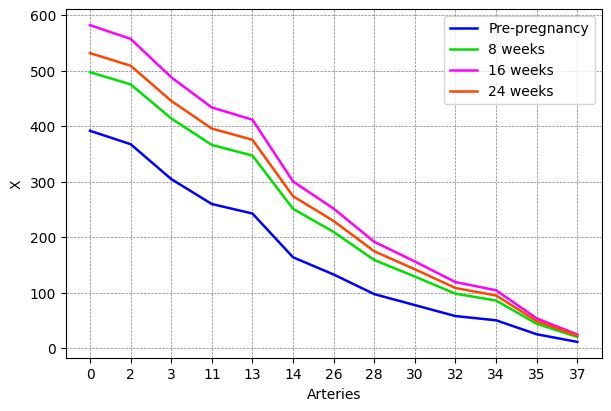

In [ ]:
dummy = range(len(rota))
plt.figure(figsize=(6, 4), layout='constrained')
plt.plot(dummy, QL_sis_plot_tr[0],'#0000ff',label='Pre-pregnancy',linewidth = '1.8')
plt.plot(dummy, QL_sis_plot_tr[1],'#00df00',label='8 weeks',linewidth = '1.8')
plt.plot(dummy, QL_sis_plot_tr[2],'#ff00ff',label='16 weeks',linewidth = '1.8')
plt.plot(dummy, QL_sis_plot_tr[3],'#ff4500',label='24 weeks',linewidth = '1.8')
plt.xticks(dummy, rota)
plt.xlabel('Arteries')
plt.ylabel('X')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()

In [ ]:
QL_sis_log_tr = np.transpose(QL_sis_log)

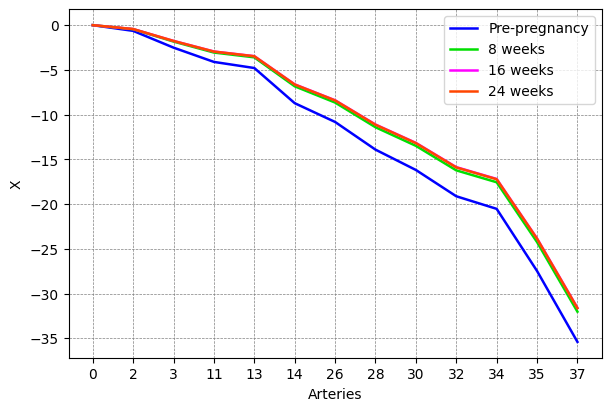

In [ ]:
plt.figure(figsize=(6, 4), layout='constrained')
plt.plot(dummy, QL_sis_log_tr[0],'#0000ff',label='Pre-pregnancy',linewidth = '1.8')
plt.plot(dummy, QL_sis_log_tr[1],'#00df00',label='8 weeks',linewidth = '1.8')
plt.plot(dummy, QL_sis_log_tr[2],'#ff00ff',label='16 weeks',linewidth = '1.8')
plt.plot(dummy, QL_sis_log_tr[3],'#ff4500',label='24 weeks',linewidth = '1.8')
plt.xticks(dummy, rota)
plt.xlabel('Arteries')
plt.ylabel('X')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()

## Velocidades

In [ ]:
################ INICIALIZAÇÃO ################
limite_r=int(rl[i]*1e3)                  #-----------------------------------------> 1001
vl = np.zeros((len(artLength),len(semanas),limite_r,len(tempos)))
vl_med = np.zeros((len(artLength),len(semanas),len(tempos)))
vl_medmed = np.zeros((len(artLength),len(semanas)))
vl_max = np.zeros((len(artLength),len(semanas),len(tempos)))
r = np.zeros((len(artLength),limite_r))
###############################################

for i in range(len(artLength)):                                                 #Calculado para todas as artérias grandes da rede
  r = np.linspace(1e-6,rl[i],limite_r)                                          #Cria vetor de raio do centro (0) ao raio total com passo definido por limite_r
  T, R = np.meshgrid(tempos,r,sparse=True);                                     #Cria plano com eixos r e t
  for s in range(len(semanas)):                                                 #Para cada trimestre de gravidez (0,8,16 e 24 semanas)
    vl[i,s] = ((1-(R)**2/rl[i]**2))/(np.pi*(rl[i]**2))*QL[i,s,0:len(tempos)]    #Fórmula em Chahibi

    for t in range(len(tempos)):
      vl_max[i,s,t] = vl[i,s,np.argmax(np.abs(vl[i,s,:,t])),t]                    #Salva velocidade do raio em que é máxima (na teoria, no centro da artéria)

    vl_med[i,s] = (1/2)*vl_max[i,s]                                             #Simplificação encontrada em DILL 2011
    vl_medmed[i,s] = np.sum(vl_med[i,s])/len(vl_med[i,s])
#   print(i, vl_medmed[i,0])

In [ ]:
T.shape, R.shape, vl.shape, vl_max.shape, vl_med.shape, vl_medmed.shape

((1, 2001),
 (200, 1),
 (40, 4, 200, 2001),
 (40, 4, 2001),
 (40, 4, 2001),
 (40, 4))

# Propagação - Inicialização

In [ ]:
"""
Inicialização de vetores (matrizes) para armazenamento dos dados de propagação para cada semana. Cada semana representará uma linha
nas matrizes abaixo. A adição é "manual" ao final da execução da propagação de cada semana. Cabe refatoração para implementação de
laço para processar as semanas em execução única.

Os vetores do primeiro bloco abaixo foram selecionados a partir da dedução do comentário "#*******************************" em linhas
de atrubuição de variáveis de resultado na execução da propagação. Entendi que deveriam ser insumos para plotagens dos resultados.
"""

vetor_tprimeira = []
vetor_t13 = []
vetor_C = []
vetor_primeira = []
vetor_absorvidos = []
vetor_irma = []
vetor_chegou = []
vetor_chegouF = []

art_med = []

G = np.zeros([len(semanas), len(rota)])

# Propagação - Execução (repetir para cada semana)

In [ ]:
"""
Execução da PROPAGAÇÃO
- Alterar a veriável "s" para execução de cada semana. No caso específico de 0 a 3 (4 semanas)
- Para não ficar demorado, reduzir as variáveis "n" e "media". Deduzi com influenciadoras das amostras, mas não cheguei a conclusões
da finalidade e ajustes de ambas. Originalmente estavam setadas em 1, cada. Cheguei a executar em 100, mas o tempo de execução fica
bem mais alto.
"""

for semana in range(len(semanas)):
  dt = 1e-1 #passo #e-4
  D=1e-2
  k= 0.02*np.sqrt(D)/np.sqrt(np.pi*dt)  #1e-5  #0.4*D
  npart = int(1e3)
  lt = len(tempos)

  ifinal=37
  H0 = 2*r_bot_saud[0]
  n=1   # Inicialmente estava setado em 1. O que eh n? Máximo tentado: 100
  # s=0   # Indicativo da semana?
  s=semana   # Indicativo da semana?

  Peu = np.zeros((len(rota))) #,n*lt))
  Pev = np.zeros(len(rota ))
  Pabs = np.zeros(len(rota))
  Pref = np.zeros(len(rota))
  primeira = np.zeros(len(rota))               #*******************************
  pos = np.zeros(npart)

  x = np.zeros((n*lt,npart))
  y = np.zeros((n*lt,npart))

  ###### INICIALIZAÇÃO ######
  for p in range(npart):
    y[0,p] = 1e-3 + (H0-2e-3)*rd.random()    # y[0] = r_bot[i]

  dTotal = np.zeros(len(rota))
  tprimeira = np.zeros(len(rota))            #*******************************
  t13 = np.zeros(len(rota))                   #*******************************

  vetoru=[]
  for i in range(len(rota)):
    ######## Valores adimensionais ########
    H = 2*r_bot_saud[rota[i]]
    cola=0
    for c in range(n):
      col=(c+1)*lt
      Peu[i] = vl_medmed[rota[i],s]   #*H/D  #10 Peu[i,cola:col]
      cola = col
    V = 1e-2  #ni/H                                #Rev=1, fluxos desacoplados
    Pev[i] = V  #*H/D
    Rev=1 #V*H/ni
    Sh=k*H/D
    Pabs[i] = 0.02 #Sh*np.sqrt(np.pi*dt) #probabilidade de absorção na parede inferior
    Pref[i] = 1-Pabs[i]

    ######## VETOR U ########
    u=[]
    passoy = 0.001 #r_bot[i]/tamanhoy
    vetory=np.arange(0,H+passoy,passoy)
    for j in vetory:
      z=(j)/H
      u.append((12/(1.4*Rev))*(-z+ (1-np.exp(-Rev*z))/(1-np.exp(-Rev))))

    vetoru.append(u)

    if rota[i]==0:
      dTotal[i] = 0.0
    else:
      dTotal[i] = getDistance(rota[i-1],pai,artLength_saud)

  media = 100     # Inicialmente estava setado em 1. O que eh media? Máximo tentado: 100
  C_art = np.zeros((media,len(rota)))
  C_med = [] #np.zeros((media,1000))
  # C_med = np.zeros((media,1000))

  for m in range(media):
    absorvidos=[]                            #*******************************
    chegou=[]
    chegouF=[]
    C=[]                                    #*******************************
    irma=[]                                 #*******************************
    a=0
    arti=np.zeros(npart, dtype = int)
    hab=0

    for t in range(1,n*lt):
      for p in range(npart):
        if p in chegouF:
          continue
        if p in irma:                                   #*******************************
          continue
        if p in absorvidos:                             #*******************************
          continue
        if p in chegou:
          if arti[p]<len(rota)-1:
            arti[p]=arti[p]+1
          chegou.remove(p)
        yindex = int(round(y[t-1,p],3) * 1000) #int(np.where(np.isclose(vetory,round(y[t-1],3)))[0])  #pra reduzir níveis, estudar condições dentro de where
        if yindex>=len(vetoru[arti[p]]):
          irma.append(p)                        #*******************************
          continue
        vu = np.array(vetoru[arti[p]])

        dx = Peu[arti[p]]*vu[yindex]*dt+  np.sqrt(2*D)*rd.gauss(0,np.sqrt(dt))# np.sqrt(D*dt)*rd.uniform(-1,1)    #incremento de Wiener = vetor gaussiano aleatório com média 0 e variância dt = desv. pad.

        if x[t-1,p]>0.9*dTotal[arti[p]]+artLength_saud[rota[arti[p]]]:
          ref=(QL_sis[arti[p],s]/QL_sis[pai[arti[p]],s])
        else:
          ref=r_bot_saud[arti[p]]
        if yindex==len(vetoru[arti[p]])*ref:

          prob1 = np.array(rd.choices(population=[0,1],weights=[0.5, 0.5],k=1))

          if prob1==1:
            f=1   #dy = Pev[arti[p]]*dt+np.sqrt(2*D)*rd.gauss(0,np.sqrt(dt))#np.sqrt(D*dt)*rd.uniform(-1,1) # np.sqrt(2)*rd.gauss(0,np.sqrt(dt))
          if prob1==0:
            f=-1  #dy = -Pev[arti[p]]*dt+ np.sqrt(2*D)*rd.gauss(0,np.sqrt(dt))#np.sqrt(D*dt)*rd.uniform(-1,1) #np.sqrt(2)*rd.gauss(0,np.sqrt(dt))
        elif yindex>len(vetoru[arti[p]])*ref:
          f=1   #dy = Pev[arti[p]]*dt+ np.sqrt(2*D)*rd.gauss(0,np.sqrt(dt))#np.sqrt(D*dt)*rd.uniform(-1,1) #np.sqrt(2)*rd.gauss(0,np.sqrt(dt))
        elif yindex<len(vetoru[arti[p]])*ref:
          f=-1  #dy = -Pev[arti[p]]*dt+ np.sqrt(2*D)*rd.gauss(0,np.sqrt(dt))#np.sqrt(D*dt)*rd.uniform(-1,1) #np.sqrt(2)*rd.gauss(0,np.sqrt(dt))

        dy = f*Pev[arti[p]]*dt+np.sqrt(2*D)*rd.gauss(0,np.sqrt(dt))
        x[t,p] = x[t-1,p] + dx                                                                        # 0 <= x <= artLength[i]
        y[t,p] = y[t-1,p] + dy                                                                        # 0 < y < r_bot[i]*2
        if y[t,p]>=r_bot_saud[arti[p]]*2:                                                      # Parede superior sempre reflete, nada é absorvido. Sh = 0

          probC = np.array(rd.choices(population=[0,1],weights=[Pabs[arti[p]], Pref[arti[p]]],k=1))   #0.5*Pabs[arti[p]]

          if probC==0:
            absorvidos.append(p)                                #*******************************
          elif probC==1:
            y[t,p] = y[t-1,p] - dy

        elif y[t,p]<=0:
          probB = np.array(rd.choices(population=[0,1],weights=[Pabs[arti[p]], Pref[arti[p]]],k=1))     #0.5*Pabs[arti[p]]
          if probB==0:
            absorvidos.append(p)                                #*******************************
          elif probB==1:
            y[t,p] = y[t-1,p] - dy

        if x[t,p]>=dTotal[rota.index(ifinal)]+artLength_saud[ifinal]:    #dTotal[len(rota)-1]
          if p in chegouF:
            continue
          else:
            chegouF.append(p)
            C_art[m,len(C_art[m])-1]+=1

        elif x[t,p]>=dTotal[arti[p]]+artLength_saud[rota[arti[p]]] and rota[arti[p]]<ifinal:   #se partícula passou do fim da artéria em que se encontra
          chegou.append(p)
          C_art[m,arti[p]]+=1                                                                    #registro que está mudando de artéria
          primeira[arti[p]+1] = primeira[arti[p]+1]+1                #*******************************   #sinalizo com 1 que primeira partícula chegou na artéria seguinte

          if primeira[arti[p]+1]==1:                                 #*******************************
            tprimeira[arti[p]+1]=t*dt                              #*******************************
          elif primeira[arti[p]+1]==0.13*npart:                     #*******************************
            t13[arti[p]+1]=t*dt                                     #*******************************

      C.append(len(chegouF))                                       #*******************************

      total = len(chegouF)+len(absorvidos)+len(irma)                #*******************************
      if total >= npart:
        break
    C_med.append(C)

  vetor_tprimeira.append(tprimeira)
  vetor_t13.append(t13)
  vetor_C.append(C)
  vetor_primeira.append(primeira)
  vetor_absorvidos.append(absorvidos)
  vetor_irma.append(irma)
  vetor_chegou.append(chegou)
  vetor_chegouF.append(chegouF)

  vetorM=[]
  for i in range(13):
    vetorM.append(np.average(C_art[:,i]))
  art_med.append(vetorM)

  for i in range(len(rota)):
    G[s,i] = 10*np.log(art_med[s][i]/npart)

In [ ]:
# Quando a variável "media" = 1, resultado = True

# C_med[0] == C,

In [ ]:
# len(C_med[0]), len(C)

In [ ]:
#print(f'{C}, \n{C_med}, \n{C_art}')

# Propagação - Acúmulo dos resultados das diversas execuções conforme a semana

In [ ]:
"""
Alimentação dos vetores com resultados de cada semana nas respectivas matrizes de acúmulo de resultados.

Executar esta célula após cada execução da propagação acima variando "s" de acordo com cada semana. Deverão ser 4 execuções.
"""

# vetor_tprimeira.append(tprimeira)
# vetor_t13.append(t13)
# vetor_C.append(C)
# vetor_primeira.append(primeira)
# vetor_absorvidos.append(absorvidos)
# vetor_irma.append(irma)
# vetor_chegou.append(chegou)
# vetor_chegouF.append(chegouF)

# vetorM=[]
# for i in range(13):
#   vetorM.append(np.average(C_art[:,i]))
# art_med.append(vetorM)


# for i in range(len(rota)):
#   G[s,i] = 10*np.log(art_med[s][i]/npart)

'\nAlimentação dos vetores com resultados de cada semana nas respectivas matrizes de acúmulo de resultados.\n\nExecutar esta célula após cada execução da propagação acima variando "s" de acordo com cada semana. Deverão ser 4 execuções.\n'

In [ ]:
"""
Criação e alimentação da matriz com dados da concentração de moléculas na arteria ilíaca em cada período de gestação.

Insumo para plotagem da Figura 4.4 da Dissertação.

Só executar após todas as execuções da propagação conforme a semana; e as subsequentes execuções de acúmulo de resultados.
"""

vetor_C_plot = vetor_C

tem=[]
for j in range(len(vetor_C_plot[0])+50):
  tem.append(j*dt)

for q in range(50):
  vetor_C_plot[0].append(vetor_C_plot[0][len(vetor_C_plot[0])-1])

l= len(vetor_C_plot[0])-len(vetor_C_plot[1])
for q in range(l):
  vetor_C_plot[1].append(vetor_C_plot[1][len(vetor_C_plot[1])-1])

l= len(vetor_C_plot[0])-len(vetor_C_plot[2])
for q in range(l):
  vetor_C_plot[2].append(vetor_C_plot[2][len(vetor_C_plot[2])-1])

l= len(vetor_C_plot[0])-len(vetor_C_plot[3])
for q in range(l):
  vetor_C_plot[3].append(vetor_C_plot[3][len(vetor_C_plot[3])-1])

In [ ]:
"""
Com "n" e "media" setados em 100, cheguei ao resultado de [568, 502, 484, 473].
Na Dissertação, menciona-se um resultado diferente (321, 260, 234 e 230) após 100 iterações. Não consegui entender como ajustar
a iteração corretamente. Contudo, a proporção de decaimento parece estar em conformidade.

Sempre com npart = int(1e3)
"""

media_absorvidos = []
for i in range(len(vetor_absorvidos)):
    media_absorvidos.append(len(vetor_absorvidos[i]))
print(f'Média de partículas absorvidas no percurso para cada estágio de gravidez: {media_absorvidos}')



Média de partículas absorvidas no percurso para cada estágio de gravidez: [601, 499, 463, 481]


In [ ]:
"""
Com "n" e "media" setados em 100, cheguei ao resultado de [329, 364, 385, 403].
Na Dissertação, menciona-se um resultado diferente (547, 614, 628 e 633) após 100 iterações. A proporção de aumento parece estar
em conformidade.

Sempre com npart = int(1e3)
"""

media_irma = []
for i in range(len(vetor_irma)):
    media_irma.append(len(vetor_irma[i]))
print(f'Média de partículas que seguiram percurso diferente para cada estágio de gravidez: {media_irma}')


Média de partículas que seguiram percurso diferente para cada estágio de gravidez: [304, 346, 385, 382]


In [ ]:
media_chegouF = []
for i in range(len(vetor_chegouF)):
    media_chegouF.append(len(vetor_chegouF[i]))
print(f'Média de partículas que chegaram ao receptor para cada estágio de gravidez: {media_chegouF}')

Média de partículas que chegaram ao receptor para cada estágio de gravidez: [95, 155, 152, 137]


In [ ]:
if (len(vetor_absorvidos) == len(vetor_irma) == len(vetor_chegouF)):
    for i in range(len(vetor_absorvidos)):
        print(f'{i}, Total: {len(vetor_absorvidos[i]) + len(vetor_irma[i]) + len(vetor_chegouF[i])}')

0, Total: 1000
1, Total: 1000
2, Total: 1000
3, Total: 1000


# Plotagens referentes à resultados da Propagação

In [ ]:
vetor_tprimeira[0]

array([ 0. ,  0.3,  1.2,  2.2,  3.5,  5.3,  8.4, 10.1, 10.7, 11.4, 17.1,
       20.6, 23.1])

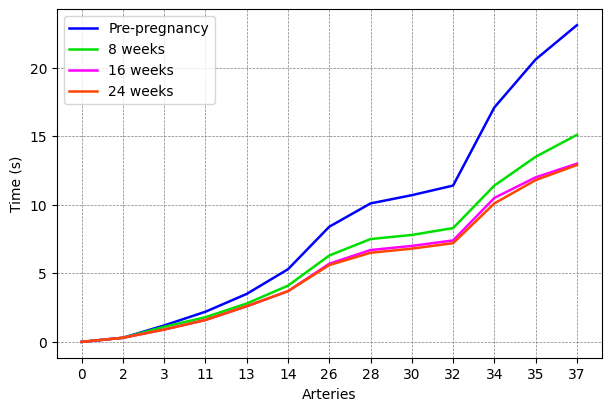

In [ ]:
# Figura 4.1 - Atraso da primeira partícula a alcançar a artéria ilíaca

plt.figure(figsize=(6, 4), layout='constrained')
plt.plot(dummy, vetor_tprimeira[0],'#0000ff',label='Pre-pregnancy',linewidth = '1.8')
plt.plot(dummy, vetor_tprimeira[1],'#00df00',label='8 weeks',linewidth = '1.8')
plt.plot(dummy, vetor_tprimeira[2],'#ff00ff',label='16 weeks',linewidth = '1.8')
plt.plot(dummy, vetor_tprimeira[3],'#ff4500',label='24 weeks',linewidth = '1.8')
plt.xticks(dummy, rota)
plt.xlabel('Arteries')
plt.ylabel('Time (s)')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()

In [ ]:
vetor_t13[0]

array([ 0. ,  0.4,  1.4,  2.5,  3.9,  5.7, 10.1, 12.8, 14.1, 15.8, 29.1,
       36.3, 38.8])

In [ ]:
vetor_tprimeira[0] + vetor_t13[0]

array([ 0. ,  0.7,  2.6,  4.7,  7.4, 11. , 18.5, 22.9, 24.8, 27.2, 46.2,
       56.9, 61.9])

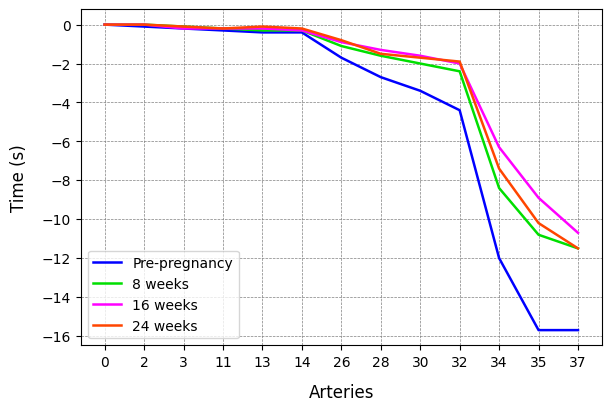

In [ ]:
# Figura 4.2 - Atraso das partículas no percurso completo // modificar p + (alterei p testar)

plt.figure(figsize=(6, 4), layout='constrained')
plt.xlabel('Arteries', fontsize = 12, labelpad = 10, color = 'k')
plt.ylabel('Time (s)',  fontsize = 12, labelpad = 10, color = 'k')
plt.plot(dummy, vetor_tprimeira[0] - vetor_t13[0],'#0000ff',label='Pre-pregnancy',linewidth = '1.8')
plt.plot(dummy, vetor_tprimeira[1] - vetor_t13[1],'#00df00',label='8 weeks',linewidth = '1.8')
plt.plot(dummy, vetor_tprimeira[2] - vetor_t13[2],'#ff00ff',label='16 weeks',linewidth = '1.8')
plt.plot(dummy, vetor_tprimeira[3] - vetor_t13[3],'#ff4500',label='24 weeks',linewidth = '1.8')
plt.xticks(dummy, rota)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()

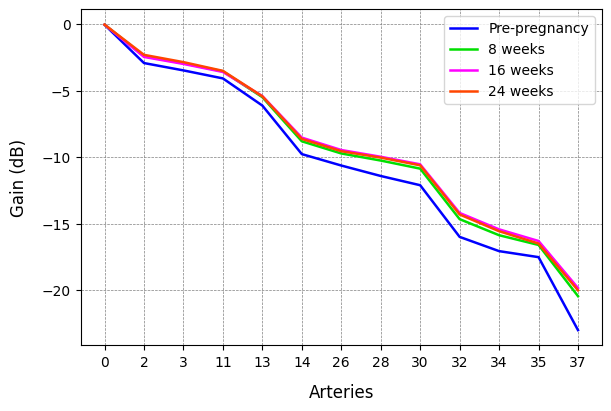

In [ ]:
# Figura 4.3 - Ganho do sistema no percuso completo

plt.figure(figsize=(6, 4), layout='constrained')
plt.xlabel('Arteries', fontsize = 12, labelpad = 10, color = 'k')
plt.ylabel('Gain (dB)',  fontsize = 12, labelpad = 10, color = 'k')
plt.plot(dummy, G[0],'#0000ff',label='Pre-pregnancy',linewidth = '1.8')
plt.plot(dummy, G[1],'#00df00',label='8 weeks',linewidth = '1.8')
plt.plot(dummy, G[2],'#ff00ff',label='16 weeks',linewidth = '1.8')
plt.plot(dummy, G[3],'#ff4500',label='24 weeks',linewidth = '1.8')
plt.xticks(dummy, rota)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()

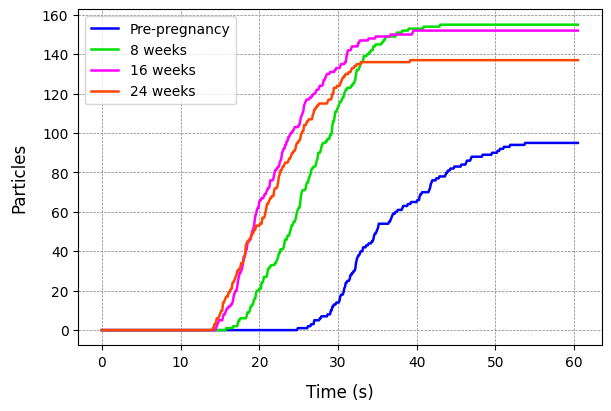

In [ ]:
# Figura 4.4 - Progressão da concentração de moléculas na artéria ilíaca

plt.figure(figsize=(6, 4), layout='constrained')
plt.xlabel('Time (s)', fontsize = 12, labelpad = 10, color = 'k')
plt.ylabel('Particles',  fontsize = 12, labelpad = 10, color = 'k')
plt.plot(tem, vetor_C_plot[0],'#0000ff',label='Pre-pregnancy',linewidth = '1.8')
plt.plot(tem, vetor_C_plot[1],'#00df00',label='8 weeks',linewidth = '1.8')
plt.plot(tem, vetor_C_plot[2],'#ff00ff',label='16 weeks',linewidth = '1.8')
plt.plot(tem, vetor_C_plot[3],'#ff4500',label='24 weeks',linewidth = '1.8')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()